In [1]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import *
from pylab import *

import seaborn as sns # poista?
from scipy import stats as sts # zipf, linreg, powerlaw
from scipy.stats import t
import scipy.optimize as opt
from scipy.stats import invgamma

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Eetun koodi

def tokenizer(words):
    # https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
    tokens_with_count = Counter(map(str.lower, book_words))
    return tokens_with_count

def token_counter(tokens_with_count):
    tokens = sorted([k for k in tokens_with_count.keys()])
    counts = np.array([tokens_with_count[k] for k in tokens])
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]
    return ranks, indices, frequencies

def sw_filter(book_words):
    stop_words = stopwords.words('english')
    stop_words.append('The')
    filtered_words = [w.lower() for w in book_words if not w.lower() in stop_words]
    ftokens_with_count = Counter(map(str.lower, filtered_words))
    topwords = [t[0] for t in ftokens_with_count.most_common(20)]
    doclen = len(ftokens_with_count)
    return filtered_words, ftokens_with_count, topwords, doclen

In [3]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

for f in files:
    file = open(f, "r", encoding='utf-8')
    b = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(b)
    file.close()

tcounts = []
tokens = []
counts = []
for b in books:
    words, tcs, _, _ = sw_filter(b)
    tokens.append(list(tcs.keys()))
    counts.append(tcs.values())
    tcounts.append(tcs)

ranks = []
freqs = []
for tc in tcounts:
    r, _, f = token_counter(tc)
    ranks.append(r)
    freqs.append(f)
    
for i in range(len(books)):
    books[i] = " ".join(books[i]).lower()
    
books = pd.DataFrame({'book_name': ["flatland", "panama-canal", "ulysses"], 
                      'book_text': books, 'ranks': ranks, 'freqs': freqs, 
                      'tokens': tokens, 'counts': counts})
books = books.set_index("book_name")

In [5]:
books.head()

,book_text,ranks,freqs,tokens,counts
book_name,,,,,
flatland,the nature flatland call our world flatland no...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[151, 107, 94, 90, 82, 81, 80, 75, 73, 71, 70,...","[nature, flatland, call, world, make, clearer,...","(40, 75, 38, 19, 34, 1, 6, 15, 4, 3, 54, 5, 6,..."
panama-canal,the project gutenberg the panama canal saxon m...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[609, 404, 299, 279, 213, 171, 162, 140, 138, ...","[project, gutenberg, panama, canal, saxon, mil...","(106, 89, 404, 609, 8, 3, 38, 5, 7, 33, 47, 3,..."
ulysses,produced david widger complete grant man propo...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1524, 1278, 1213, 1110, 1047, 871, 840, 836, ...","[produced, david, widger, complete, grant, man...","(11, 3, 1, 47, 53, 182, 2, 5, 1, 90, 28, 38, 7..."


# Task 6.

In [4]:
def expcutoff(x, alpha, beta):
    return x**(-alpha) * np.exp(-beta * x)

<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in exp
  return x**(-alpha) * np.exp(-beta * x)
<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in multiply
  return x**(-alpha) * np.exp(-beta * x)


0.38238866298458635 0.0016503176444079759


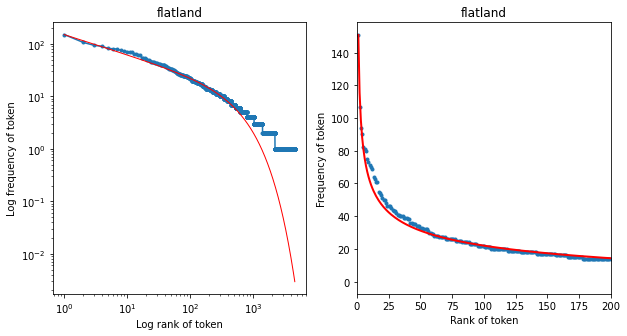

<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in exp
  return x**(-alpha) * np.exp(-beta * x)
<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in multiply
  return x**(-alpha) * np.exp(-beta * x)


0.6059706061256304 0.0005166817213862945


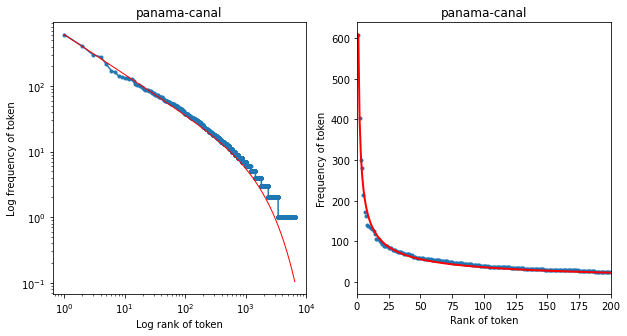

<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in exp
  return x**(-alpha) * np.exp(-beta * x)
<ipython-input-4-3486bb749fcd>:2: RuntimeWarning: overflow encountered in multiply
  return x**(-alpha) * np.exp(-beta * x)


0.4018969634115976 0.0015480116562265076


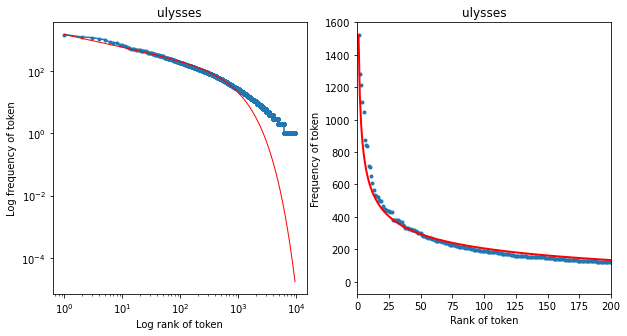

In [6]:
for b in books.index:
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    # Estimate parameters
    y_norm = (books.freqs[b] - min(books.freqs[b])) / (max(books.freqs[b]) - min(books.freqs[b])) # min-max normalisation
    fit = opt.curve_fit(expcutoff, books.ranks[b], y_norm)
    alpha, beta = fit[0]
    p = expcutoff(books.ranks[b], alpha, beta)
    
    print(alpha, beta)

    # Plot loglog
    axs[0].set_title(b)
    axs[0].loglog(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[0].plot(books.ranks[b], p * max(books.freqs[b]), lw=1, color='red') # expcutoff
    axs[0].set_xlabel("Log rank of token")
    axs[0].set_ylabel("Log frequency of token")
    
    # Plot linear
    axs[1].set_title(b)
    axs[1].scatter(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[1].plot(books.ranks[b], p * max(books.freqs[b]), lw=2, color='red') # expcutoff
    axs[1].set_xlim(0, 200)
    axs[1].set_xlabel("Rank of token")
    axs[1].set_ylabel("Frequency of token")
    
    plt.show()